In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import scipy.fftpack


Variable initialization

In [2]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion


C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [3]:
for i in range(M):
    # define the atom
    a = np.zeros(M)
    a[i] = 1
    DCT[:, i] = sp.fftpack.idct(a, norm='ortho')

Generating the 1-D standard basis

In [4]:
for i in range(M):
    a = np.zeros(M)
    a[i] = 1
    C[:, i] = a

Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

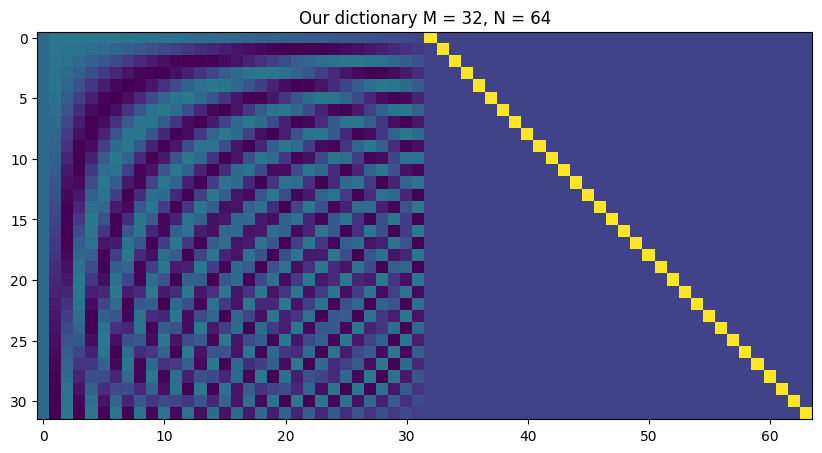

In [5]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $[D, C]$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [6]:
L = 5
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

In [7]:
x0 = np.zeros(N)
indexs = np.random.randint(0,M,L)
x0[indexs] = np.random.rand(L) * 10



Choose spike location and update x0

In [8]:
spikeLocation = np.random.randint(M,N,1)
x0[spikeLocation] += 10

Synthetize the corresponding signal in the signal domain and add noise


In [9]:
s0 = np.dot(D, x0)

s = s0 + np.random.normal(size=(M)) * sigma_noise

Plot the sparse signal

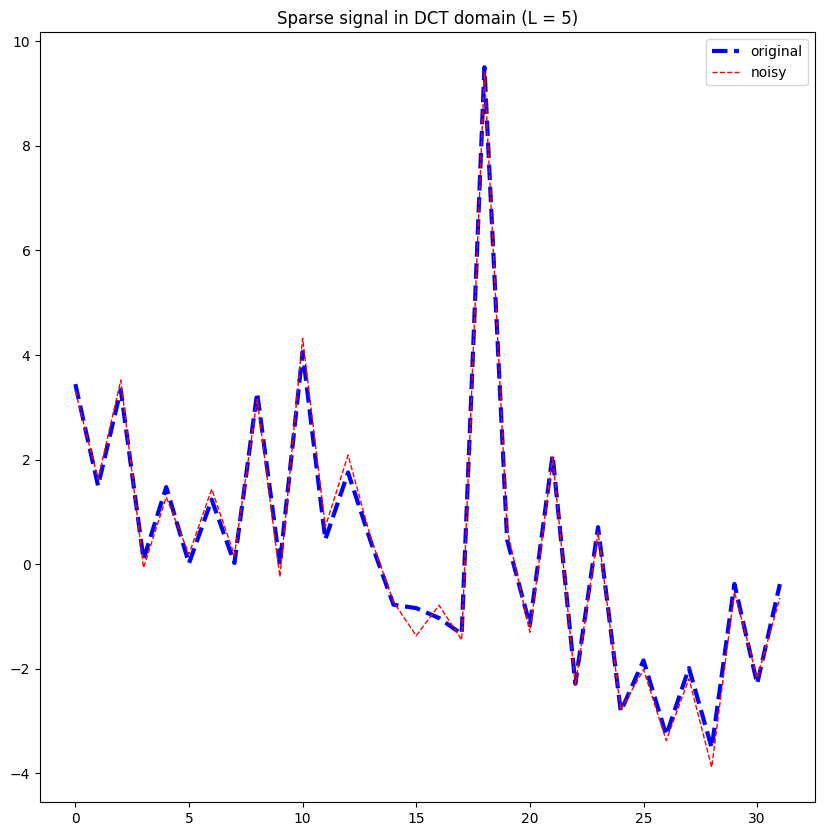

In [10]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(10,10))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Tichonov's Regularization
-----------------------
Compute the representation w.r.t. $D$ using Tichonov's regularization

In [11]:
lmbda = 1

x_tic = np.linalg.solve(np.dot(np.transpose(D),D) + lmbda * np.identity(N), np.dot(np.transpose(D), s))

s_hat_tic = np.dot(D, x_tic)

Show the results

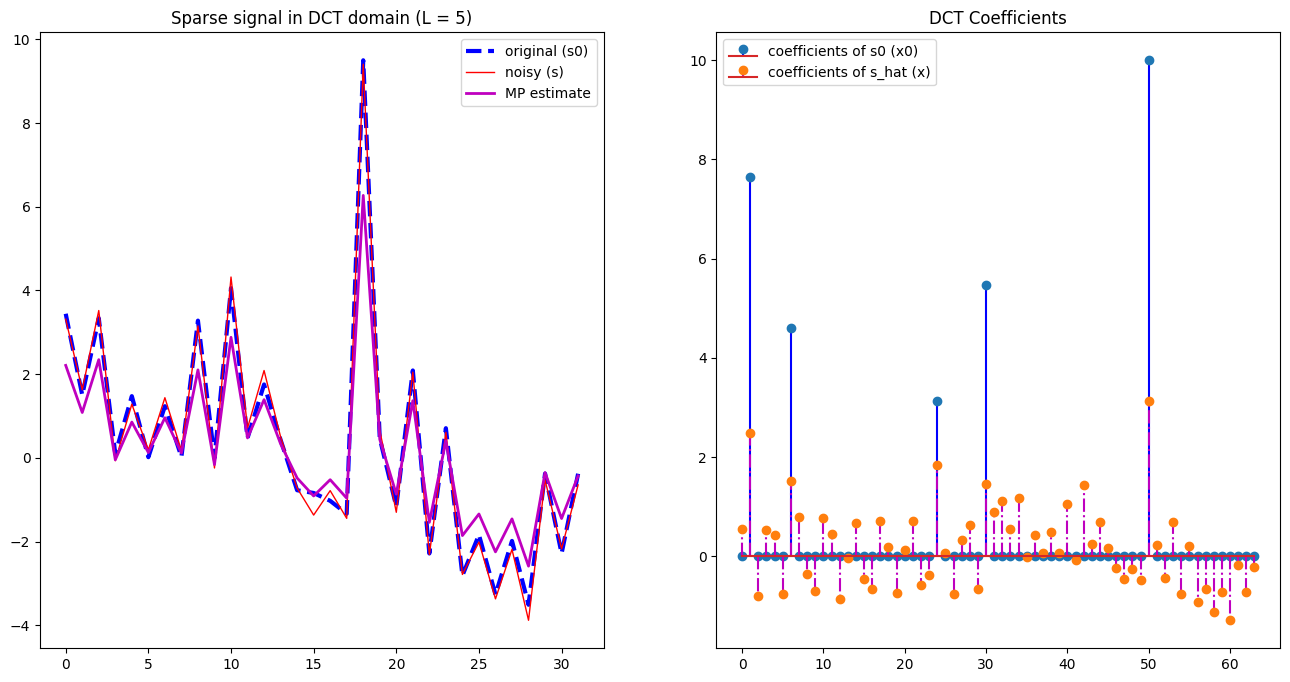

In [12]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b--', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_tic, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal in DCT domain (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_tic, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x)'])

Matching Pursuit
----------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [13]:
x_MP = np.zeros(N)

r = s

l = 1

#initialize the norm of the resiudal (components not represented by the coefficients)

resNorm = np.linalg.norm(r, ord=2)

MINIMUM_RES_NORM = 0.1


MP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L or as long as resNorm(l) is above a minimum value or as long as a maxium number of iterations have been reached

In [14]:
while np.count_nonzero(x_MP) < L and resNorm > MINIMUM_RES_NORM and l < 2*L:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        dj = D[:,j].copy()
        e[j] = (resNorm**2) - (np.dot(np.transpose(r), dj)**2) / (np.linalg.norm(dj, ord=2)**2)
        # this corresponds to solving e(j) = min( || dj zj - s ||),
        # which is obtained by setting zj = dj' r / || dj ||^2 (analytically defined)
        # there is no need to divide by || dj ||^2 since columns are nomalized

    # find the column of D that matches at best r, i.e. jStar = argmin(e(j))
    jStar = np.argmin(e)

    # UPDATE the jStar coefficient by *summing* the new component dj' r^(i) / || dj ||^2
    dstar = D[:,jStar].copy()
    x_MP[jStar] += np.dot(np.transpose(r), dstar) / (np.linalg.norm(dstar, ord=2)**2)

    # remove the signal we have so far represented in coeff_MP (update the residual)
    r = s - np.dot(D,x_MP)

    l = l + 1

    # update the residual norm
    resNorm = np.linalg.norm(r, ord=2)

SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [15]:
s_hat_MP = np.dot(D, x_MP)

Those part of the signal that have not been modeled by s_hat (i.e. the projection on the subspace of the L most involved coefficients) corresponds to the norm of the residual

In [16]:
resNorm_MP = np.linalg.norm(s - s_hat_MP, ord=2)
resNorm_MP

1.1585055158231952

Show the result

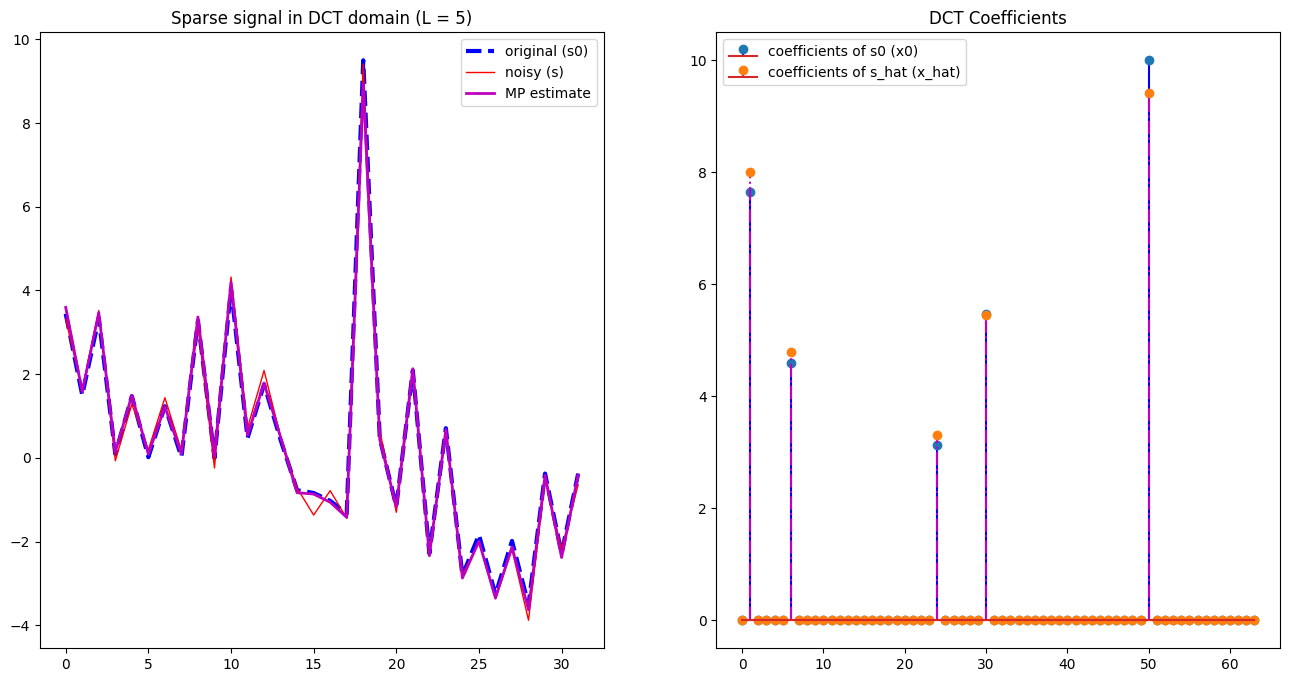

In [17]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b--', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_MP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal in DCT domain (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_MP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])